In [2]:
import pandas as pd
import numpy as np
import os
import h5py
from sklearn import linear_model
import matplotlib.pyplot as plt
import plotly.graph_objects as go
#import deepdish as dd
import math
import scipy
import scipy.stats as stats
#import seaborn as sns
import glob
from matplotlib.animation import FuncAnimation
import kaleido
from statsmodels.stats.multitest import multipletests
nv = 40962

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
from nilearn import plotting, datasets, surface, image

import plotly.io as pio
pio.renderers.default = 'vscode'
def plot_mesh(vals,
              hem='lh',
              cmap='cold_hot',
              threshold=None,
              symmetric_cbar=True,
              title='',
              vmax=None,
              engine='matplotlib',
              avg_method = 'mean',
              colorbar = True,
              bg_on_data = True):
    fsaverage = datasets.fetch_surf_fsaverage('fsaverage6')
    surface_bg_lh = np.loadtxt('lh.partial_inflated0010.asc')[:,:3]
    surface_bg_rh = np.loadtxt('rh.partial_inflated0010.asc')[:,:3]
    
    # there's def a better way to do this, but this just sets the nan values to right below the min
    # of our actual data
    # so we set the threshold to the datamin, and now we dont see the nans
    nanmin = np.nanmin(vals)
    vals = np.nan_to_num(vals, copy=True, nan=0)
#     if threshold is None:
#         threshold = nanmin-2
    if hem=='lh':
        # mesh = surface.load_surf_mesh(fsaverage.infl_left)
        mesh = [surface_bg_lh[:40962,:].astype(float),surface_bg_lh[40962:,:].astype(int)]
        hemi = 'left' 
        bg_map = fsaverage.sulc_left
    else:
        # mesh = surface.load_surf_mesh(fsaverage.infl_right)
        mesh = [surface_bg_rh[:40962,:].astype(float),surface_bg_rh[40962:,:].astype(int)]
        hemi = 'right'
        bg_map = fsaverage.sulc_right
    for v in ['medial', 'lateral']:
        if engine == 'matplotlib':    
            fig = plotting.plot_surf_stat_map(mesh,
                                        vals,
                                        hemi=hemi,
                                        cmap=cmap,
                                        vmax=vmax,
                                        view=v,
                                        colorbar=colorbar,
                                        threshold=threshold,
                                        title=title,
                                        bg_map=bg_map,
                                        symmetric_cbar=symmetric_cbar,
                                        bg_on_data=bg_on_data,
                                        darkness = 1,
                                        engine=engine,
                                        avg_method=avg_method)
            fig.savefig(f'output/{title}_{v}_{hemi}.png',dpi=300)
        else:
            fig = plotting.plot_surf_stat_map(mesh,
                                        vals,
                                        hemi=hemi,
                                        cmap=cmap,
                                        vmax=vmax,
                                        view=v,
                                        colorbar=False,
                                        threshold=threshold,
                                        title=title,
                                        bg_map=bg_map,
                                        symmetric_cbar=symmetric_cbar,
                                        bg_on_data=bg_on_data,
                                        engine=engine,
                                        output_file = f'{title}_{v}_{hemi}.png')
        
        fig.show()


In [4]:
mpfc = h5py.File('mPFC_verts.h5', 'r')
ag = h5py.File('Ang_verts.h5', 'r')
pmc = h5py.File('PMC_verts.h5', 'r')
roi_mask_l = np.zeros((nv))
roi_mask_r = np.zeros((nv))

#or roi_idx, roi_file in enumerate([ag, mpfc, pmc]):
roi_mask_l[np.array(mpfc['left'])] = int(2)
roi_mask_r[np.array(mpfc['right'])] = int(2)

roi_mask_l[np.array(ag['left'])] = int(1)
roi_mask_r[np.array(ag['right'])] = int(1)

roi_mask_l[np.array(pmc['left'])] = int(3)
roi_mask_r[np.array(pmc['right'])] = int(3)



/var/folders/5w/cyx3lt1j5f9357p4syt378ph0000gn/T/ipykernel_16742/244219898.py:71: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



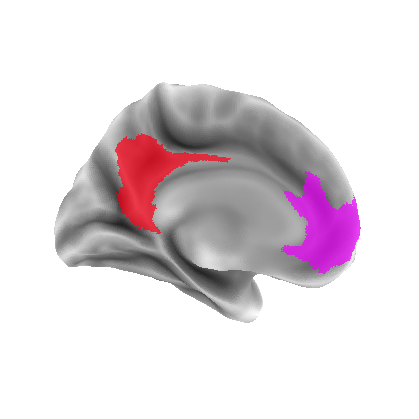

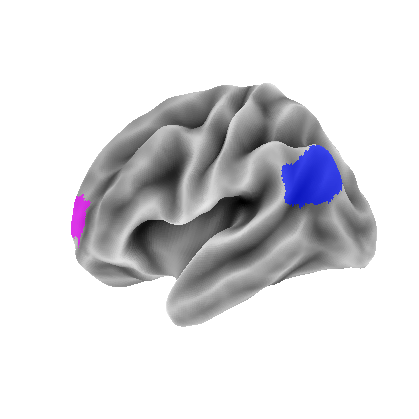

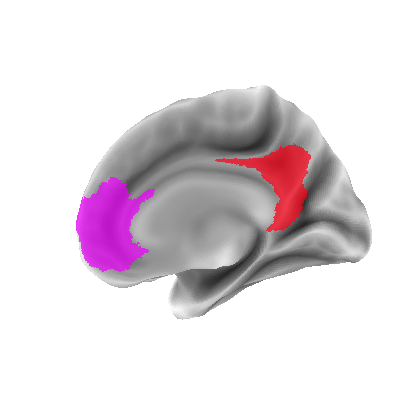

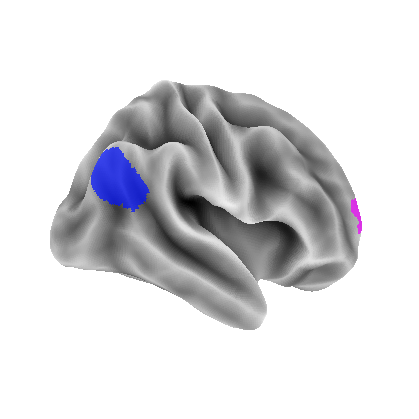

In [40]:
plot_mesh(roi_mask_l, hem='lh',cmap='hsv',threshold=0.1, avg_method='median',bg_on_data=True,colorbar=False)
plot_mesh(roi_mask_r, hem='rh',cmap='hsv',threshold=0.1, avg_method='median',bg_on_data=True,colorbar=False)

In [5]:
subjects = ['sub-%.2d'%s for s in range(1,26)]


def plot_task_permutation(task, vmax = None):
    sub_l = []
    sub_r = []
    sub_l_r = []
    sub_r_r = []

    for sub in subjects:
        zVals_l = []
        zVals_r = []
        rVals_l = []
        rVals_r = []
        for ses in ['ses-01','ses-02','ses-03']:
            zVals_l.append(np.loadtxt(f'/Volumes/data/MoL_clean/outputs/brain_maps/{sub}_{ses}_{task}_SL_z.lh.dset')[:,0])
            zVals_r.append(np.loadtxt(f'/Volumes/data/MoL_clean/outputs/brain_maps/{sub}_{ses}_{task}_SL_z.rh.dset')[:,0])
            rVals_l.append(np.loadtxt(f'/Volumes/data/MoL_clean/outputs/brain_maps/{sub}_{ses}_{task}_diag_mean_lh.txt'))
            rVals_r.append(np.loadtxt(f'/Volumes/data/MoL_clean/outputs/brain_maps/{sub}_{ses}_{task}_diag_mean_rh.txt'))

        sub_l.append(np.mean(np.array(zVals_l),axis=0))
        sub_r.append(np.mean(np.array(zVals_r),axis=0))
        sub_l_r.append(np.mean(np.array(rVals_l),axis=0))
        sub_r_r.append(np.mean(np.array(rVals_r),axis=0))

    sub_l = np.array(sub_l)
    sub_r = np.array(sub_r)
    sub_rVal_l = np.mean(np.array(sub_l_r),axis=0)
    sub_rVal_r =  np.mean(np.array(sub_r_r),axis=0)
    
    sub_lr = np.concatenate((sub_l,sub_r),axis=1)
    _, p_vals = np.apply_along_axis(lambda x: stats.ttest_1samp(x, 0), axis=0, arr=sub_lr)
    p_vals_corrected = multipletests(p_vals, method='fdr_bh')[1]

    p_adjusted_l = p_vals_corrected[:40962]
    p_adjusted_r = p_vals_corrected[40962:]

    sub_rVal_l[np.where(p_adjusted_l>.05)]=0
    print(max(sub_rVal_l))
    plot_mesh(sub_rVal_l, hem='lh', threshold=0.0000001, title=f'{task} correlation', symmetric_cbar=True, vmax = vmax)
    #t_threshold = np.min(abs(t_stats_r[np.where(p_adjusted_r<.05)]))
    #r_threshold = np.min(abs(sub_rVal_r[np.where(abs(t_stats_r)>t_threshold)]))
    sub_rVal_r[np.where(p_adjusted_r>.05)]=0
    print(max(sub_rVal_r))
    plot_mesh(sub_rVal_r, hem='rh',threshold=0.0000001,  title=f'{task} correlation', symmetric_cbar=True, vmax = vmax)
    #return sub_rVal_l, sub_rVal_r

0.07444514976852427


/var/folders/5w/cyx3lt1j5f9357p4syt378ph0000gn/T/ipykernel_5505/61269374.py:71: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



0.06900648943179305


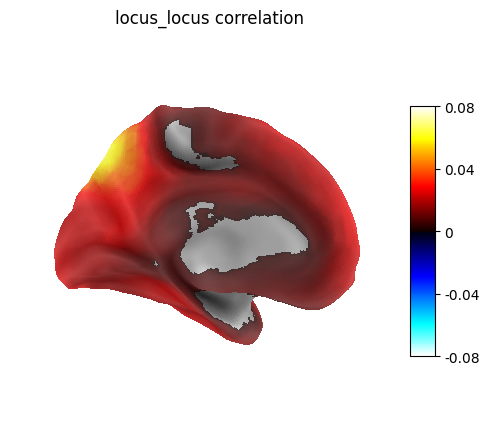

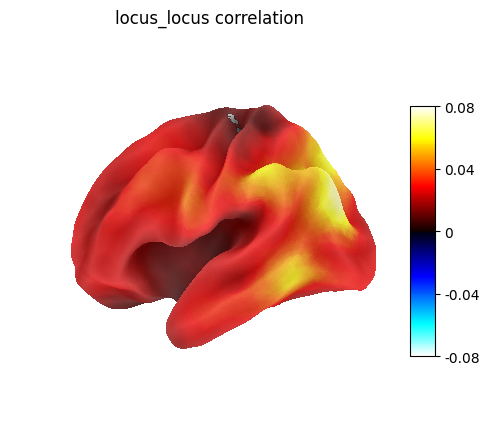

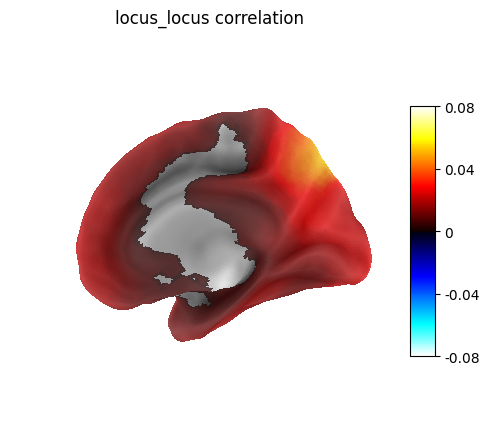

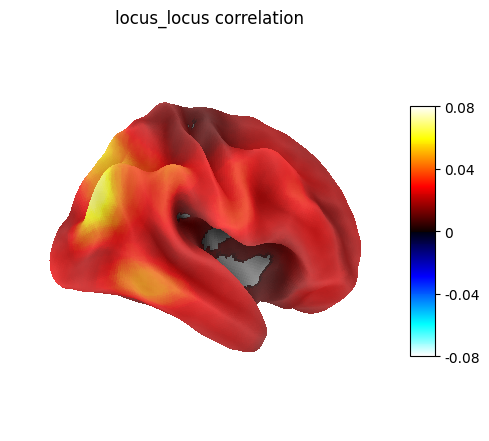

In [6]:
plot_task_permutation('locus_locus',vmax=.08)

0.038711166670340476


/var/folders/5w/cyx3lt1j5f9357p4syt378ph0000gn/T/ipykernel_16742/61269374.py:71: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



0.032561045407601075


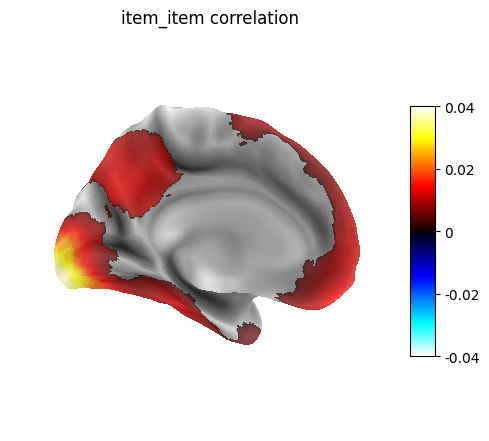

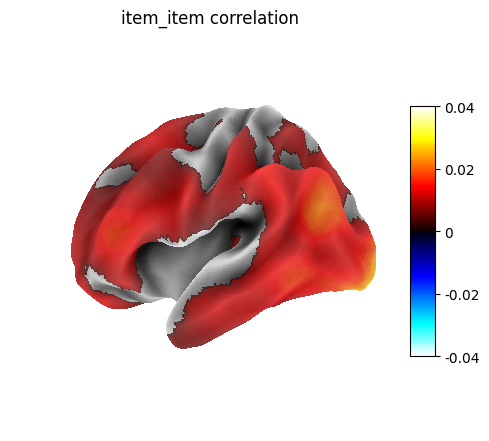

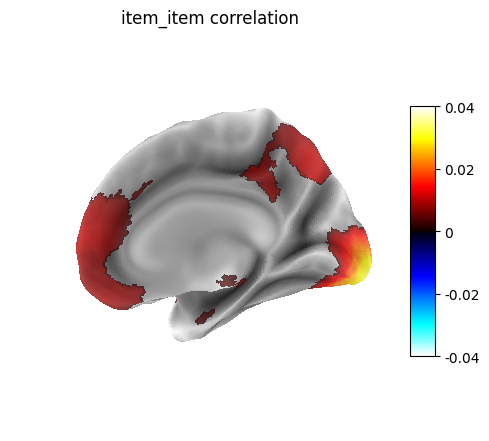

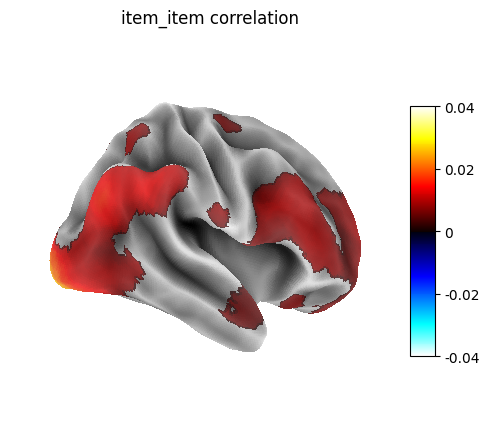

In [66]:
plot_task_permutation('item_item',vmax = .04)

0.03888547278263434


/var/folders/5w/cyx3lt1j5f9357p4syt378ph0000gn/T/ipykernel_16742/61269374.py:71: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



0.0330712839094423


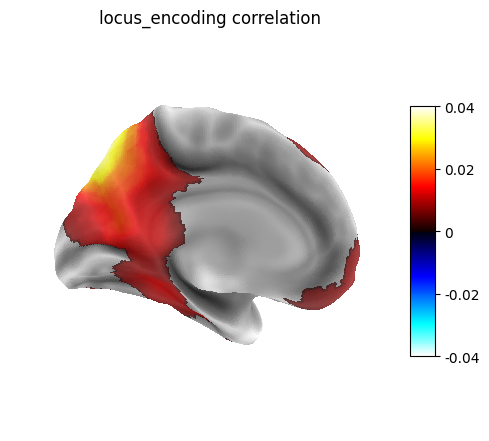

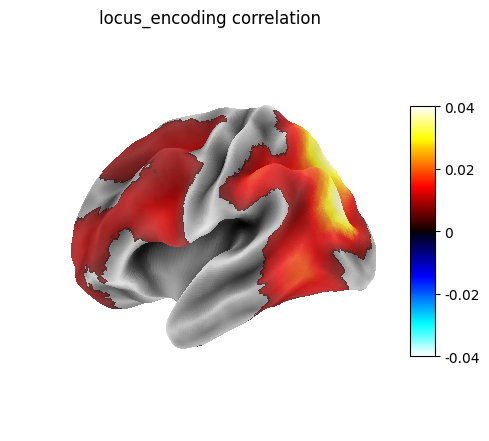

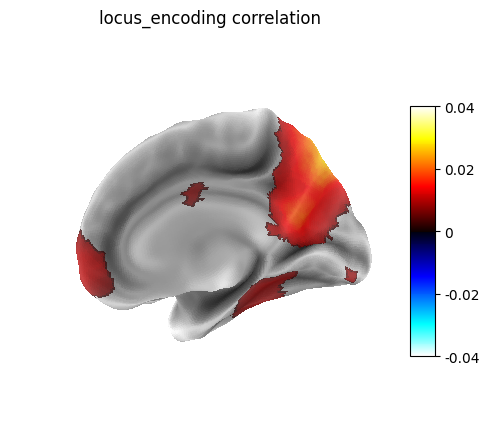

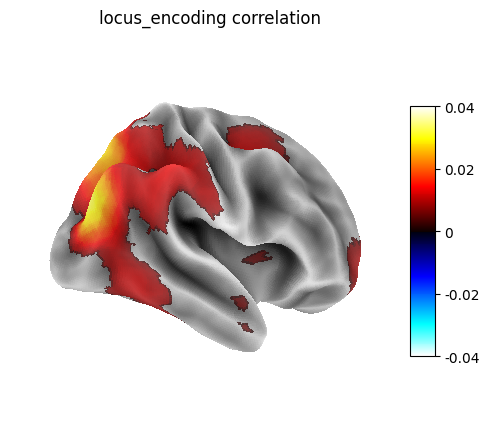

In [67]:
plot_task_permutation('locus_encoding', vmax=.04)

0.05853929150647497


/var/folders/5w/cyx3lt1j5f9357p4syt378ph0000gn/T/ipykernel_16742/61269374.py:71: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



0.05101836236039224


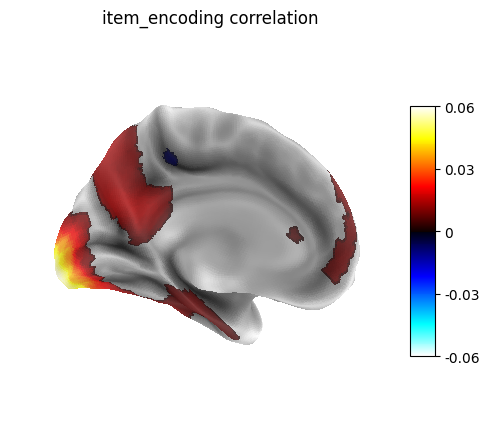

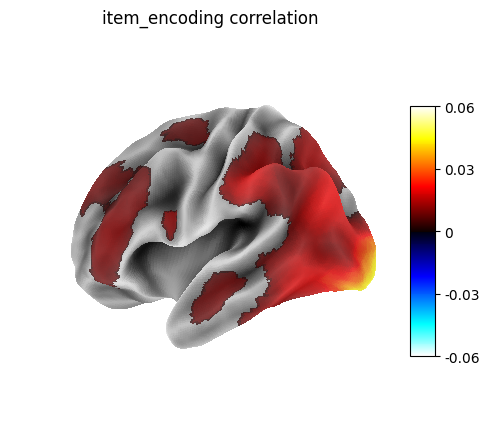

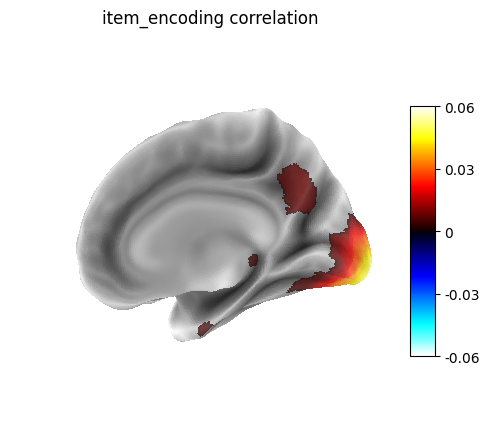

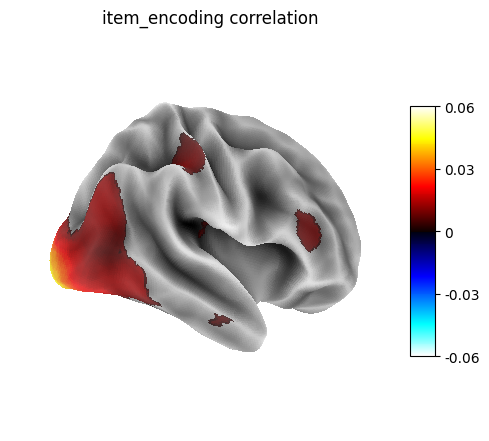

In [68]:
plot_task_permutation('item_encoding',vmax=.06)

In [69]:
task = 'locus'
sub_l = []
sub_r = []

for sub in subjects:
    sub_l.append(np.loadtxt(f'/Volumes/data/MoL_clean/outputs/regression_weights_predict_retrieval/{sub}_vox_{task}_weights_z_lh.txt'))
    sub_r.append(np.loadtxt(f'/Volumes/data/MoL_clean/outputs/regression_weights_predict_retrieval/{sub}_vox_{task}_weights_z_rh.txt'))
    

array([6.07250349e-01, 2.55668437e-04, 1.43573836e-01, ...,
       7.19562827e-02, 6.65942079e-02, 5.79300699e-02])

In [71]:
p_vals_corrected.shape

(81924,)

In [87]:
def plot_task_regression_weights(task,t='', note = '',version = 'z'):
    sub_l = []
    sub_r = []
    sub_l_beta = []
    sub_r_beta = []
    for sub in subjects:
        sub_l.append(np.loadtxt(f'/Volumes/data/MoL_clean/outputs/regression_weights_predict_retrieval/{sub}_vox_{task}_weights_z_lh.txt'))
        sub_r.append(np.loadtxt(f'/Volumes/data/MoL_clean/outputs/regression_weights_predict_retrieval/{sub}_vox_{task}_weights_z_rh.txt'))
        
    sub_lr = np.concatenate((sub_l,sub_r),axis=1)
    _, p_vals = np.apply_along_axis(lambda x: stats.ttest_1samp(x, 0), axis=0, arr=sub_lr)
    p_vals_corrected = multipletests(p_vals, method='fdr_bh')[1]

    
    sub_Zvals_l = np.mean(np.array(sub_l),axis=0)
    sub_Zvals_r = np.mean(np.array(sub_r),axis=0)

    
    p_adjusted_l = p_vals_corrected[:40962]
    p_adjusted_r = p_vals_corrected[40962:]

    threshold_l = np.min(abs(sub_Zvals_l[np.where(p_adjusted_l<.05)]))
    print(max(abs(sub_Zvals_l)))
    try:
        threshold_r = np.min(abs(sub_Zvals_r[np.where(p_adjusted_r<.05)]))
    except:
        threshold_r = max(abs(sub_Zvals_r))
        plot_mesh(sub_Zvals_r, threshold=threshold_r, hem='rh', title=f'{task} weight {t} {note}', symmetric_cbar=True)
        return None
    print(max(abs(sub_Zvals_r)))   

    if version == 'z':
        plot_mesh(sub_Zvals_l, hem='lh', threshold=threshold_l, title=f'{task} z_beta {t} {note}', symmetric_cbar=True, vmax = 0.43)
        plot_mesh(sub_Zvals_r, hem='rh', threshold=threshold_r, title=f'{task} z_beta {t} {note}', symmetric_cbar=True, vmax = 0.43)

    if version == 'beta':
        for sub in subjects:
            sub_l_beta.append(np.loadtxt(f'/Volumes/data/MoL_clean/outputs/regression_weights_predict_retrieval/{sub}_vox_{task}_weights_lh.txt'))
            sub_r_beta.append(np.loadtxt(f'/Volumes/data/MoL_clean/outputs/regression_weights_predict_retrieval/{sub}_vox_{task}_weights_rh.txt'))

        sub_betas_l = np.mean(np.array(sub_l_beta),axis=0)
        sub_betas_r = np.mean(np.array(sub_r_beta),axis=0)
        sub_betas_l[p_adjusted_l>.05] = 0
        sub_betas_r[p_adjusted_r>.05] = 0
        print(max(abs(sub_betas_l)))
        print(max(abs(sub_betas_r))) 
    
        plot_mesh(sub_betas_l, hem='lh', threshold=0.0000001, title=f'{task} beta {t} {note}', symmetric_cbar=True)
        plot_mesh(sub_betas_r, hem='rh', threshold=0.0000001, title=f'{task} beta {t} {note}', symmetric_cbar=True)


/var/folders/5w/cyx3lt1j5f9357p4syt378ph0000gn/T/ipykernel_16742/61269374.py:71: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



0.19648591360549714
0.15135097181938553


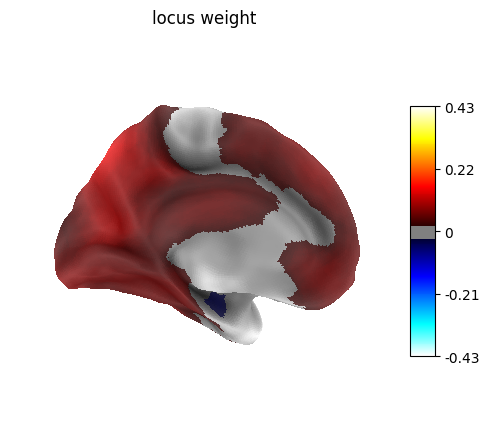

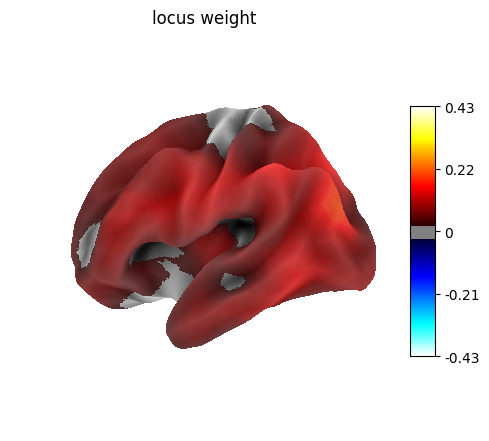

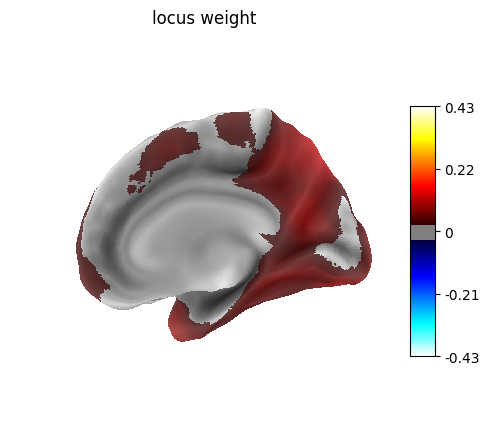

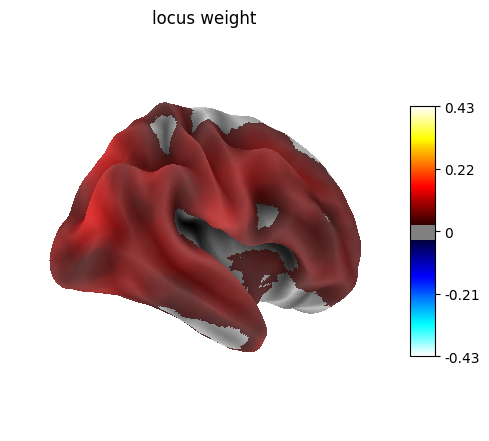

In [73]:
plot_task_regression_weights('locus')


/var/folders/5w/cyx3lt1j5f9357p4syt378ph0000gn/T/ipykernel_16742/61269374.py:71: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



0.11258279255112459
0.05744753888427125


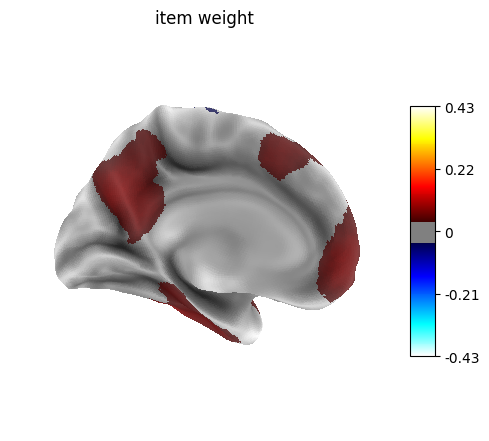

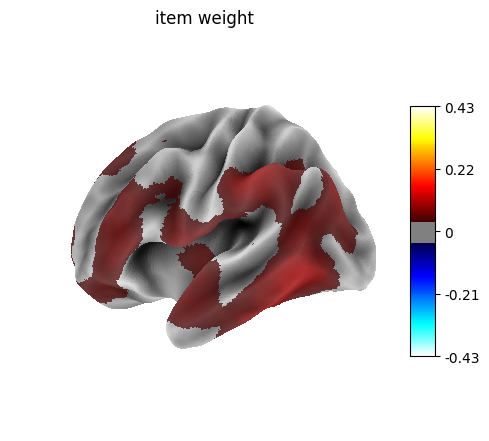

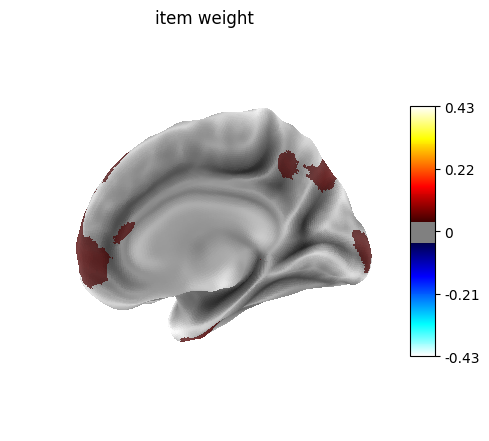

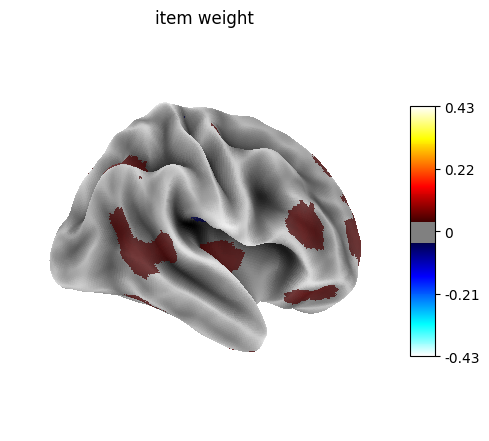

In [74]:
plot_task_regression_weights('item')

/var/folders/5w/cyx3lt1j5f9357p4syt378ph0000gn/T/ipykernel_16742/61269374.py:71: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



0.4295206362126631
0.36409685741244024


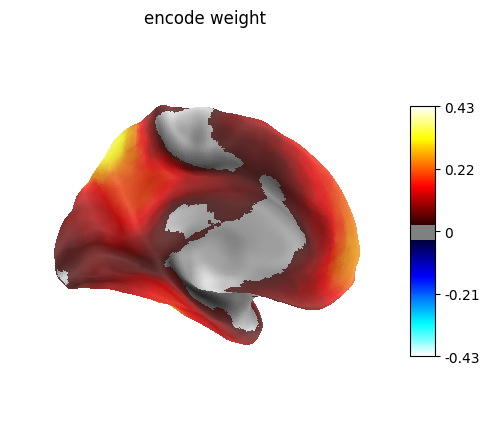

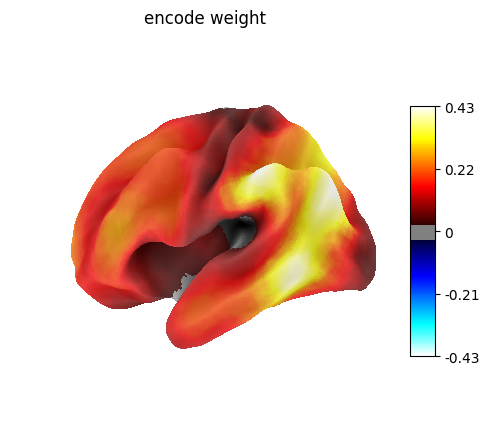

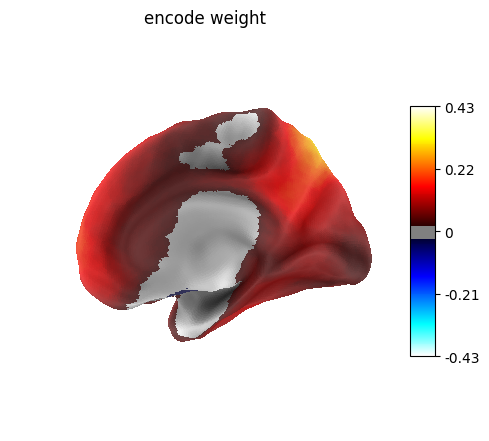

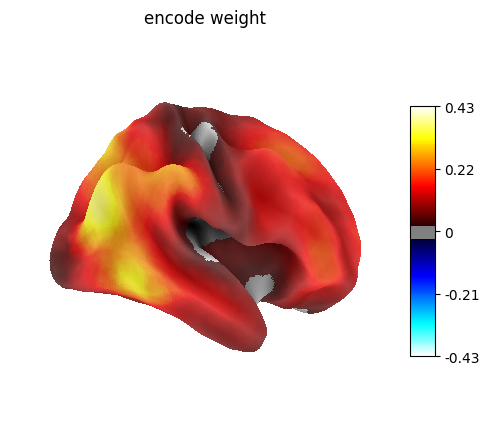

In [75]:
plot_task_regression_weights('encode')

In [76]:
def plot_task_regression_weights_diff(task_to_compare = 'locus', t='', note = '',vmax = 18.59):
    sub_l_t1 = []
    sub_r_t1 = []
    sub_l_t2 = []
    sub_r_t2 = []
    for sub in subjects:
        task = 'retrieve'
        sub_l_t1.append(np.loadtxt(f'/Volumes/data/MoL_clean/outputs/regression_weights_predict_retrieval/{sub}_vox_{task}_weights_z_lh.txt'))
        sub_r_t1.append(np.loadtxt(f'/Volumes/data/MoL_clean/outputs/regression_weights_predict_retrieval/{sub}_vox_{task}_weights_z_rh.txt'))
        sub_l_t2.append(np.loadtxt(f'/Volumes/data/MoL_clean/outputs/regression_weights_predict_retrieval/{sub}_vox_{task_to_compare}_weights_z_lh.txt'))
        sub_r_t2.append(np.loadtxt(f'/Volumes/data/MoL_clean/outputs/regression_weights_predict_retrieval/{sub}_vox_{task_to_compare}_weights_z_rh.txt'))
    sub_l = np.array(sub_l_t1) - np.array(sub_l_t2)
    sub_r = np.array(sub_r_t1) - np.array(sub_r_t2)
    sub_lr = np.concatenate((sub_l,sub_r),axis=1)
    t_stats, p_vals = np.apply_along_axis(lambda x: stats.ttest_1samp(x, 0), axis=0, arr=sub_lr)
    p_vals_corrected = multipletests(p_vals, method='fdr_bh')[1]
    t_stats_l, p_adjusted_l = t_stats[:40962], p_vals_corrected[:40962]
    t_stats_r, p_adjusted_r = t_stats[40962:], p_vals_corrected[40962:]
    
    threshold = np.min(abs(t_stats_l[np.where(p_adjusted_l<.05)]))
    plot_mesh(t_stats_l, hem='lh', threshold=threshold, title=f'Encoding-{task_to_compare} weight difference {t} {note}', symmetric_cbar=True, vmax = vmax)
    print(max(abs(t_stats_l)))
    t_stats_r, p_values_r = np.apply_along_axis(lambda x: stats.ttest_1samp(x, 0), axis=0, arr=sub_r)
    p_adjusted_r = multipletests(p_values_r, method='fdr_bh')[1]
    try:
        threshold = np.min(abs(t_stats_r[np.where(p_adjusted_r<.05)]))
    except:
        threshold = 0
        t_stats_r = np.zeros(t_stats_r.shape)
        
    print(max(abs(t_stats_r)))        
    plot_mesh(t_stats_r, hem='rh', threshold=threshold, title=f'Encoding-{task_to_compare} weight difference {t} {note}', symmetric_cbar=True, vmax = vmax)

/var/folders/5w/cyx3lt1j5f9357p4syt378ph0000gn/T/ipykernel_16742/61269374.py:71: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



10.752740003386856
8.008923827433676


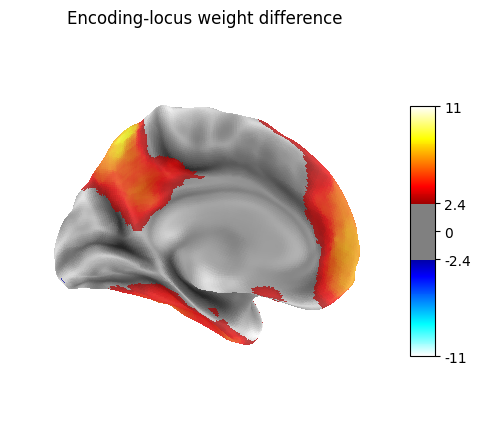

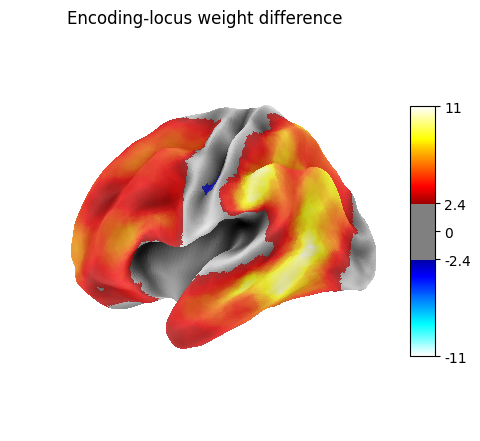

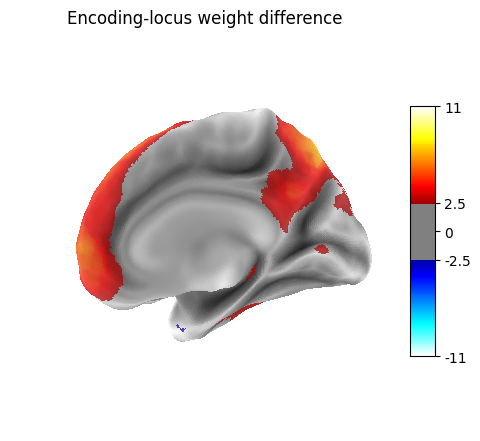

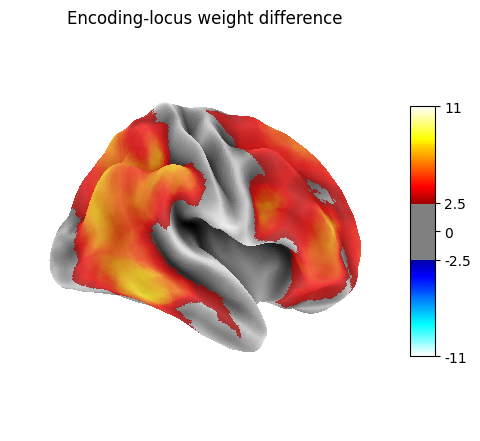

In [77]:
plot_task_regression_weights_diff('locus',vmax=10.8)

/var/folders/5w/cyx3lt1j5f9357p4syt378ph0000gn/T/ipykernel_16742/61269374.py:71: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



14.55842468582601
10.01346099561417


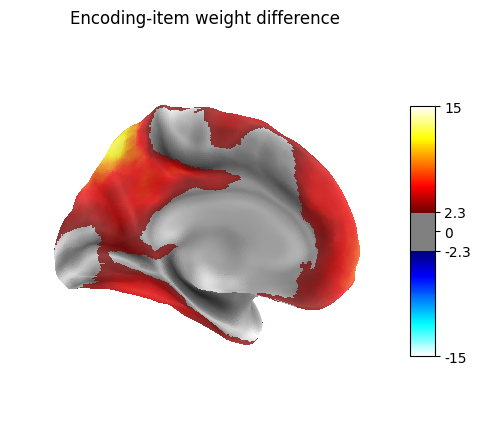

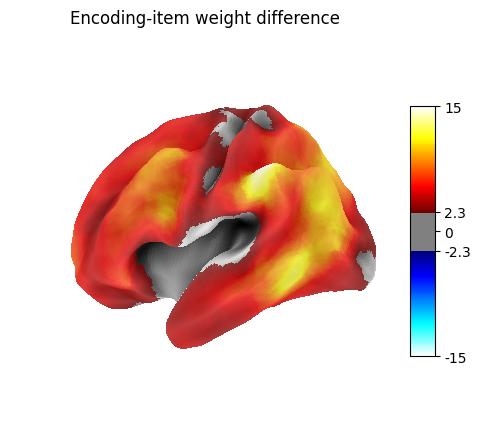

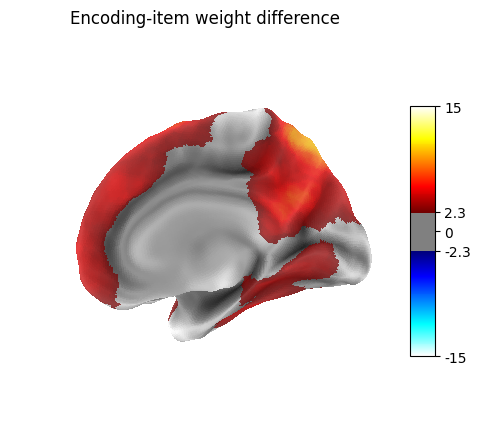

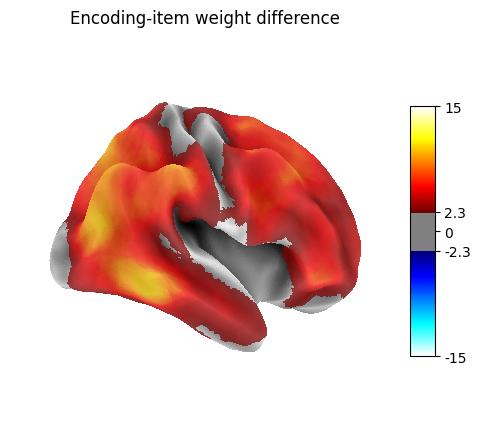

In [78]:
plot_task_regression_weights_diff('item',vmax = 14.6)